# CFAR

<a href="https://rookiepeng.github.io/radarsimpy/" target="_blank" rel="nofollow"><img src="https://img.shields.io/badge/Documentation-latest-brightgree?style=flat&logo=read-the-docs" height="20" align="left"></a>

<br></br>
This is an example of Constant False Alarm Rate (CFAR) threshold for an FMCW radar.
[`RadarSimPy`](https://github.com/rookiepeng/radarsimpy) has two buildin CFAR methods: `CA-CFAR` and `OS-CFAR`.

## Radar Model
### Transmitter

Setup the basic transmitter parameters through `Transmitter` module.

The following table lists the parameters in this example.

 | Parameter                       | Variable in `Transmitter`| Value                |
 |---------------------------------|--------------------------|----------------------|
 | Frequency ($f$)                 | `f`                      | [24.075, 24.175] GHz |
 | Time ($T$)                      | `t`                      | 80e-6 s              |
 | Transmitted power ($P_t$)       | `tx_power`               | 10 dBm               |
 | Pulse repetition period ($PRP$) | `prp`                    | 100 us               |
 | Number of pulses                | `pulses`                 | 1                    |

Here, `f` and `t` define the frequency modulation of the transmitter. The frequency changes from `24.075 GHz` to `24.175 GHz` within `80e-6 s`.

The radiation pattern os the transmitter antenna is $\cos{\theta}$. The gain of the antenna is 6 dB.


In [1]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

angle = np.arange(-90, 91, 1)
pattern = 20 * np.log10(np.cos(angle / 180 * np.pi) + 0.01) + 6

tx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)

tx = Transmitter(f=[24.075e9, 24.175e9],
                 t=80e-6,
                 tx_power=20,
                 prp=100e-6,
                 pulses=1,
                 channels=[tx_channel])


### Receiver

Setup the receiver parameters through `Receiver` module.

The parameters of the receiver are listed in the table below.

 | Parameter                        | Variable in `Receiver`   | Value        |
 |----------------------------------|--------------------------|--------------|
 | Sampling rate ($f_s$)            | `fs`                     | 2 Msps       |
 | Noise figure ($NF$)              | `noise_figure`           | 12 dB        |
 | RF gain/loss ($G_{rf}$)          | `rf_gain`                | 20 dB        |
 | Load resistor ($R_L$)            | `load_resistor`          | 500 $\Omega$ |
 | Baseband voltage gain ($G_{BB}$) | `baseband_gain`          | 30 dB        |

 The radiation pattern os the receiver antenna is $\cos{\theta}$. The gain of the antenna is 6 dB.

In [2]:
rx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)

rx = Receiver(fs=2e6,
              noise_figure=12,
              rf_gain=20,
              load_resistor=500,
              baseband_gain=30,
              channels=[rx_channel])


 Create the FMCW radar model based on all the parameters defined above.

In [3]:
radar = Radar(transmitter=tx, receiver=rx)


### Targets

The propertities of targets are defined here. The locations of the targets are defined through $(x, y, z)$ coordinates in meters, and the speeds of the targets are defined trough $(v_x, v_y, v_z)$ in $m/s$. The propertites of the targets also includes radar cross-section (RCS (dBsm)) and phase (degree).

In [4]:
target_1 = dict(location=(95, 20, 0), speed=(-50, 0, 0), rcs=20, phase=0)
target_2 = dict(location=(30, -5, 0), speed=(-22, 0, 0), rcs=10, phase=0)

targets = [target_1, target_2]


## Simulate Baseband Signals
 
Use the `simulator` module to simulate the baseband samples. The user can choose between Python engine `simpy` or C++ engine `simc`.

The output baseband data is a 3-D matrix:

$[channels, pulses, ADC~samples]$
 
#### Simulate with C++ engine

In [5]:
from radarsimpy.simulator import simc

data = simc(radar, targets)
time_matrix = data['timestamp']
data_matrix = data['baseband']


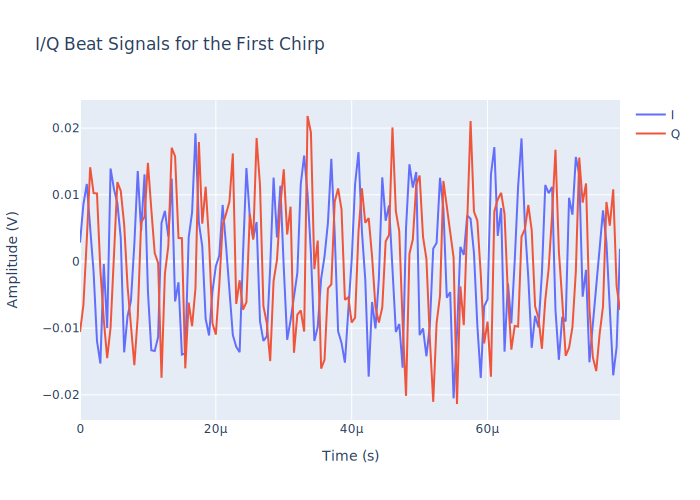

In [6]:
import plotly.graph_objs as go
from IPython.display import SVG, display

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=time_matrix[0, 0, :],
    y=np.real(data_matrix[0, 0, :]),
    name='I',
))
fig.add_trace(go.Scatter(
    x=time_matrix[0, 0, :],
    y=np.imag(data_matrix[0, 0, :]),
    name='Q',
))

fig.update_layout(
    title='I/Q Beat Signals for the First Chirp',
    yaxis=dict(title='Amplitude (V)'),
    xaxis=dict(title='Time (s)'),
)

# fig.show()
display(SVG(fig.to_image(format='svg', scale=1)))


 ## Radar Signal Processing
 ### Range profile and CFAR

In [7]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.chebwin(radar.samples_per_pulse, at=60)
range_profile = proc.cal_range_profile(radar, data_matrix, range_window)

ca_cfar = proc.cfar_ca(range_profile[0, 0, :], guard=2, trailing=10, pfa=1e-2)
os_cfar = proc.cfar_os(range_profile[0, 0, :], n=20, k=14, pfa=1e-2)


Plot range profile and CFAR

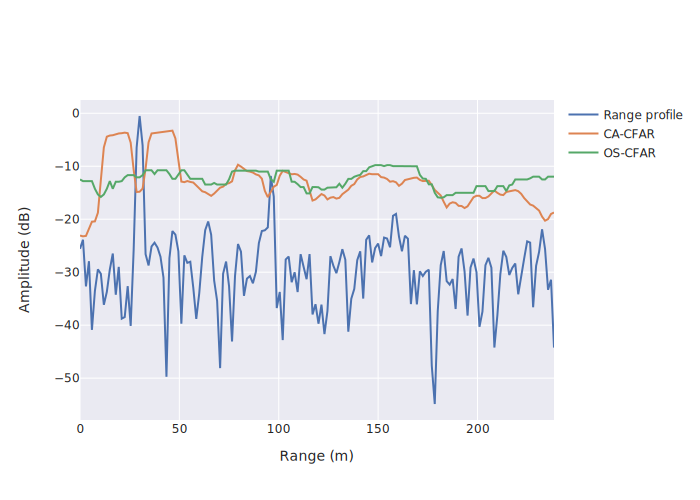

In [8]:
max_range = (3e8 * radar.receiver.fs *
             radar.transmitter.pulse_length /
             radar.transmitter.bandwidth / 2)
range_axis = np.linspace(
    0, max_range, radar.samples_per_pulse, endpoint=False)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=range_axis,
    y=20*np.log10(np.abs(range_profile[0, 0, :])),
    name='Range profile',
))

fig.add_trace(go.Scatter(
    x=range_axis,
    y=20*np.log10(ca_cfar),
    name='CA-CFAR'
))

fig.add_trace(go.Scatter(
    x=range_axis,
    y=20*np.log10(os_cfar),
    name='OS-CFAR'
))

fig.update_layout(
    # title='Range Profile',
    template="seaborn",
    yaxis=dict(title='Amplitude (dB)'),
    xaxis=dict(title='Range (m)'),
)

# fig.show()
display(SVG(fig.to_image(format='svg', scale=1)))
# fig.write_image('cfar.svg', height=400, width=600)
